In [72]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("movies.csv")
print(f"Loaded {len(df)} rows")

Loaded 2199 rows


In [61]:
# temporal splot
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year


# normalize to between 0 - 1
df['vote_norm'] = df['vote_average'] / 10.0
df['is_good'] = (df['vote_norm'] >= 0.68).astype(int)

print(f"Class Balance:\n{df['is_good'].value_counts(normalize=True)}")

train_df = df[df['release_year'] < 2019].copy()
test_df = df[df['release_year'] >= 2019].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.0f}%) | {train_df['release_year'].min()}-{train_df['release_year'].max()}")
print(f"Test:  {len(test_df)} ({len(test_df)/len(df)*100:.0f}%) | {test_df['release_year'].min()}-{test_df['release_year'].max()}")

Class Balance:
is_good
1    0.521601
0    0.478399
Name: proportion, dtype: float64
Train: 1799 (82%) | 1903-2018
Test:  400 (18%) | 2019-2026


In [62]:
for d in [train_df, test_df]:
    d['primary_genre'] = d['genres'].fillna('Unknown').str.split('|').str[0]

num_features = ['budget', 'runtime', 'release_year']
cat_features = ['primary_genre']
target = 'is_good'

X_train = train_df[num_features + cat_features]
y_train = train_df[target]
X_test = test_df[num_features + cat_features]
y_test = test_df[target]

# pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=10))])

In [78]:
pipeline.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


Accuracy: 0.5825

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.70      0.55       148
           1       0.74      0.52      0.61       252

    accuracy                           0.58       400
   macro avg       0.60      0.61      0.58       400
weighted avg       0.64      0.58      0.59       400



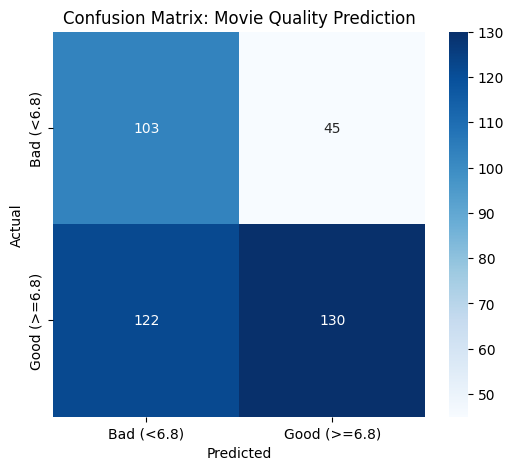

In [79]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bad (<6.8)', 'Good (>=6.8)'], 
            yticklabels=['Bad (<6.8)', 'Good (>=6.8)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Movie Quality Prediction')
plt.show()